In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "LSD"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn003131,MWRLPYIAYVCTWGNKCEMLLLSNGEPCASSLPNYSCLNFGFTILH...,238,1
1,EMT22195,MQSQIVCHGCRSVLLYPRGAPSVCCAVCHAVTNAPPPGMEMAQLIC...,197,1
2,EMT24478,MPVPLAPYPTPPVPFTPPAPNAGAQSQLVCSGCRNLLMYPAGATSV...,146,1
3,AA53G00240,MNIAGSGNGGQSQLVCSGCRNLLMYPVGATSVCCAVCNAVTAVPPP...,120,1
4,AA57G00277,LFRIESIPSPIEVFPGFDLDSGFGSKLSSIFLNPFEFQDKIRNILL...,225,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
612,0.010870,0.000000,0.000000,0.0,0.000000,0.016304,0.005435,0.000000,0.000000,0.000000,...,0.0,0.010870,0.005435,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
649,0.009901,0.000000,0.000000,0.0,0.000000,0.000000,0.009901,0.004950,0.000000,0.004950,...,0.0,0.004950,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1323,0.004494,0.000000,0.002247,0.0,0.002247,0.006742,0.006742,0.002247,0.004494,0.002247,...,0.0,0.002247,0.000000,0.0,0.002247,0.002247,0.0,0.0,0.0,0.0
96,0.000000,0.000000,0.000000,0.0,0.000000,0.005208,0.015625,0.000000,0.000000,0.005208,...,0.0,0.010417,0.000000,0.0,0.000000,0.005208,0.0,0.0,0.0,0.0
793,0.000000,0.005714,0.005714,0.0,0.000000,0.000000,0.011429,0.005714,0.000000,0.005714,...,0.0,0.011429,0.000000,0.0,0.005714,0.005714,0.0,0.0,0.0,0.0


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1511, 439)
X_test: (378, 439)
y_train: (1511,)
y_test: (378,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,905 (609.00 KB)

 Trainable params: 155,905 (609.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 11s 666ms/step - accuracy: 0.4531 - loss: 0.6931

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6712 - loss: 0.6748 - val_accuracy: 0.9802 - val_loss: 0.5338


Epoch 2/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.5627

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9501 - loss: 0.4487 - val_accuracy: 0.9934 - val_loss: 0.1878


Epoch 3/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.1997

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9811 - loss: 0.1548 - val_accuracy: 0.9967 - val_loss: 0.0377


Epoch 4/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0637

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9844 - loss: 0.0670 - val_accuracy: 0.9934 - val_loss: 0.0277


Epoch 5/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0577

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9912 - loss: 0.0391 - val_accuracy: 0.9934 - val_loss: 0.0251


Epoch 6/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0225

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9952 - loss: 0.0323 - val_accuracy: 0.9934 - val_loss: 0.0179


Epoch 7/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0824

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0351 - val_accuracy: 0.9967 - val_loss: 0.0142


Epoch 8/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0119

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.0240 - val_accuracy: 0.9967 - val_loss: 0.0134


Epoch 9/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0094

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9984 - loss: 0.0131 - val_accuracy: 0.9967 - val_loss: 0.0182


Epoch 10/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0252

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9983 - loss: 0.0109 - val_accuracy: 0.9967 - val_loss: 0.0219


Epoch 11/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0045

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9951 - loss: 0.0199 - val_accuracy: 0.9835 - val_loss: 0.0402


Epoch 12/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0897

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0216 - val_accuracy: 0.9967 - val_loss: 0.0099


Epoch 13/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0019

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9982 - loss: 0.0064 - val_accuracy: 0.9967 - val_loss: 0.0088



[Train Accuracy: 99.75% - Test Accuracy: 99.74%]


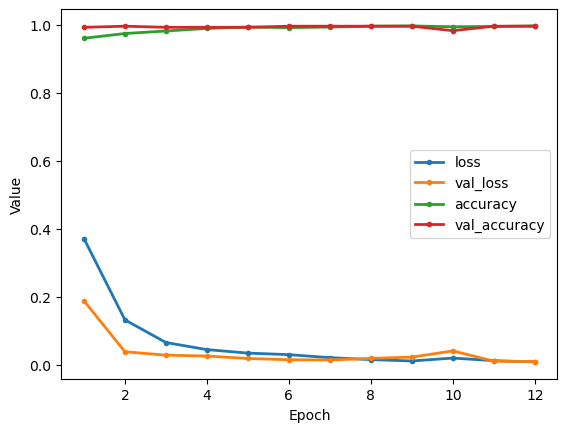

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
612,0.0,0.0,0.0,0.0,0.0,0.005464,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
649,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1323,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
793,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1511, 8369)
X_test: (378, 8369)
y_train: (1511,)
y_test: (378,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,142,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,185,985 (8.34 MB)

 Trainable params: 2,185,985 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 11s 639ms/step - accuracy: 0.5312 - loss: 0.6931

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6919 - loss: 0.6906   

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7780 - loss: 0.6836

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8014 - loss: 0.6783 - val_accuracy: 0.9538 - val_loss: 0.5412


Epoch 2/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9688 - loss: 0.5508

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9787 - loss: 0.4981 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9771 - loss: 0.4468

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9766 - loss: 0.4286 - val_accuracy: 0.9769 - val_loss: 0.0796


Epoch 3/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9688 - loss: 0.0989

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9850 - loss: 0.0659 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9885 - loss: 0.0533

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9893 - loss: 0.0501 - val_accuracy: 0.9934 - val_loss: 0.0162


Epoch 4/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.0193

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9938 - loss: 0.0106 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9956 - loss: 0.0087

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9960 - loss: 0.0082 - val_accuracy: 0.9967 - val_loss: 0.0089


Epoch 5/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0018

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9967 - val_loss: 0.0081


Epoch 6/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0021

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9901 - val_loss: 0.0170


Epoch 7/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.1010e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.6734e-04 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5859e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7526e-04 - val_accuracy: 0.9967 - val_loss: 0.0042


Epoch 8/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 4.4788e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.4077e-04 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9500e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.8332e-04 - val_accuracy: 0.9967 - val_loss: 0.0072


Epoch 9/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.3969e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5013e-04 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1138e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9903e-04 - val_accuracy: 0.9967 - val_loss: 0.0104


Epoch 10/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.7929e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8485e-04 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8827e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8714e-04 - val_accuracy: 0.9967 - val_loss: 0.0123


Epoch 11/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.2846e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5961e-04 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6115e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6518e-04 - val_accuracy: 0.9967 - val_loss: 0.0097


Epoch 12/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.6522e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3212e-04 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1354e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0548e-04 - val_accuracy: 0.9967 - val_loss: 0.0064


Epoch 13/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.8986e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.4572e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.5227e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.5171e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.4853e-04 - val_accuracy: 0.9967 - val_loss: 0.0091


Epoch 14/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 8.3677e-05

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8177e-05 

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.8883e-05

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0182e-04 - val_accuracy: 0.9967 - val_loss: 0.0114



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


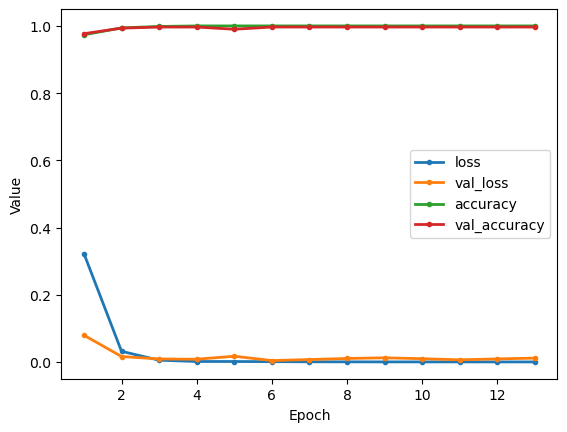

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYX,YYYY
612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      27,860,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,901,441 (106.44 MB)

 Trainable params: 27,901,441 (106.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 16s 891ms/step - accuracy: 0.4844 - loss: 0.6931

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5117 - loss: 0.6929  

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5043 - loss: 0.6930

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5062 - loss: 0.6929

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5068 - loss: 0.6926

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5048 - loss: 0.6924

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5070 - loss: 0.6922

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5132 - loss: 0.6919

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5225 - loss: 0.6915

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5339 - loss: 0.6910

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5459 - loss: 0.6905

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5574 - loss: 0.6900

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5688 - loss: 0.6895

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5800 - loss: 0.6888

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5908 - loss: 0.6881

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6011 - loss: 0.6874

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6111 - loss: 0.6866

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6206 - loss: 0.6857

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6295 - loss: 0.6849

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.6376 - loss: 0.6841 - val_accuracy: 0.9670 - val_loss: 0.6019


Epoch 2/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9688 - loss: 0.5911

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9766 - loss: 0.5915 

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9774 - loss: 0.5903

 4/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9782 - loss: 0.5880

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9794 - loss: 0.5850

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9807 - loss: 0.5816

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9819 - loss: 0.5779

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9829 - loss: 0.5741

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9838 - loss: 0.5700

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9847 - loss: 0.5657

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9854 - loss: 0.5612

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9860 - loss: 0.5565

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9865 - loss: 0.5517

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9870 - loss: 0.5469

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9874 - loss: 0.5420

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9878 - loss: 0.5371

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9881 - loss: 0.5321

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9883 - loss: 0.5271

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9884 - loss: 0.5222

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9886 - loss: 0.5178 - val_accuracy: 0.9670 - val_loss: 0.2300


Epoch 3/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9688 - loss: 0.2233

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.9766 - loss: 0.2178 

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9809 - loss: 0.2101

 4/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9827 - loss: 0.2039

 5/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9843 - loss: 0.1976

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9856 - loss: 0.1918

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9867 - loss: 0.1862

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9877 - loss: 0.1813

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9884 - loss: 0.1765

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9891 - loss: 0.1720

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9897 - loss: 0.1677

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9903 - loss: 0.1637

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9906 - loss: 0.1600

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9910 - loss: 0.1564

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9912 - loss: 0.1532

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9914 - loss: 0.1501

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9916 - loss: 0.1472

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9918 - loss: 0.1444

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9920 - loss: 0.1416

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9921 - loss: 0.1392 - val_accuracy: 0.9736 - val_loss: 0.0509


Epoch 4/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9844 - loss: 0.0465

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9883 - loss: 0.0391 

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9905 - loss: 0.0342

 4/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9919 - loss: 0.0311

 5/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9929 - loss: 0.0288

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9936 - loss: 0.0270

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9942 - loss: 0.0258

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9947 - loss: 0.0248

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9951 - loss: 0.0239

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9954 - loss: 0.0232

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9957 - loss: 0.0225

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9960 - loss: 0.0219

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9962 - loss: 0.0213

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9964 - loss: 0.0207

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9965 - loss: 0.0202

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9967 - loss: 0.0198

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9968 - loss: 0.0193

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9970 - loss: 0.0189

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9971 - loss: 0.0185

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9972 - loss: 0.0181 - val_accuracy: 0.9769 - val_loss: 0.0364


Epoch 5/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 1.0000 - loss: 0.0027

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0025 

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0025

 4/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0025

 5/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0025

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0025

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0026

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0026

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0027

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0027

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0028

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0028

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0028

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0029

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0029

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0029

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0029

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0029

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0029

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9868 - val_loss: 0.0242


Epoch 6/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 1.0000 - loss: 0.0016

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 0.0018 

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0018

 4/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 0.0017

 5/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0017

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0016

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0016

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 0.0016

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0016

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0016

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0015

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0015

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0015

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0015

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0015

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 0.0015

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0015

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9802 - val_loss: 0.0305


Epoch 7/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 1.0000 - loss: 5.6516e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0010    

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0011

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0012

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0012

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0011

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0011

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0011

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0011

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0011

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0011

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0011

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0011

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0010

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0010

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0010

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0010

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0010

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 0.0010

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9802 - val_loss: 0.0322


Epoch 8/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 4.3429e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 5.1117e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 5.5385e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.6589e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.6396e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.6752e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.6845e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.8857e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 6.0238e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 6.1008e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.1455e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.1736e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.1949e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.2101e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.2270e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.2275e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.2218e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.2260e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 6.2261e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 6.2261e-04 - val_accuracy: 0.9835 - val_loss: 0.0264


Epoch 9/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 1.0000 - loss: 4.6861e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 1.0000 - loss: 4.7584e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 4.8127e-04 

 4/19 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 4.9487e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 4.9820e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 5.0638e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 5.1932e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 5.2559e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 5.3113e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.3245e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 5.3174e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.3110e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.2947e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.2682e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 5.2354e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 5.2058e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 5.1766e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 5.1526e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 5.1295e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 5.1088e-04 - val_accuracy: 0.9802 - val_loss: 0.0333


Epoch 10/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 7.3963e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 6.6266e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 7.0414e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.9341e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.7930e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.8361e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 6.7819e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 6.6825e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 6.5662e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 6.4637e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 6.3569e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 6.2427e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 6.1434e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 6.0525e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 5.9786e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 5.9043e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.8358e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.7749e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 5.7135e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 5.6581e-04 - val_accuracy: 0.9835 - val_loss: 0.0301


Epoch 11/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 2.2829e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.1454e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.0886e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.0366e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.0889e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.1142e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.1360e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.3001e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.4078e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.4780e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.5364e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.5779e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6055e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6339e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6566e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6706e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6795e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6831e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.6848e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 2.6863e-04 - val_accuracy: 0.9835 - val_loss: 0.0306


Epoch 12/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 1.4963e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.5174e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.7150e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.7829e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.8513e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.8939e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9173e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9300e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9400e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9582e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9685e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9762e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9784e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9777e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9835e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9886e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9907e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9895e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.9886e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.9878e-04 - val_accuracy: 0.9802 - val_loss: 0.0359


Epoch 13/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 1.1407e-04

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 1.1516e-04

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.1996e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3975e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.4828e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.5167e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.5526e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.5762e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.5973e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.6126e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.6179e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.6444e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.6723e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.6943e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.7107e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.7237e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.7330e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.7380e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.7423e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.7463e-04 - val_accuracy: 0.9802 - val_loss: 0.0354


Epoch 14/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 6.4392e-05

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 8.1006e-05

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 8.2592e-05

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 8.3746e-05

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.5648e-05

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.8379e-05

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.0031e-05

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.3225e-05

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 9.6343e-05

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 9.8601e-05

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0058e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.0258e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0456e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.0638e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.0814e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.0954e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1095e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.1208e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.1297e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.1376e-04 - val_accuracy: 0.9802 - val_loss: 0.0400


Epoch 15/100


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 8.2799e-05

 2/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 9.3153e-05

 3/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.2168e-04

 4/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.3154e-04

 5/19 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.3465e-04

 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.3752e-04

 7/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.3791e-04

 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.3704e-04

 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.3533e-04

10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3418e-04

11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3248e-04

12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3144e-04

13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3052e-04

14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3052e-04

15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3019e-04

16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.2959e-04

17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.2893e-04

18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.2827e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.2753e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.2686e-04 - val_accuracy: 0.9802 - val_loss: 0.0425



[Train Accuracy: 100.00% - Test Accuracy: 99.21%]


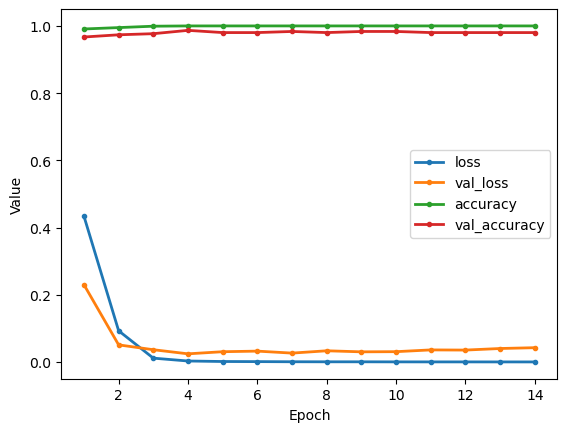

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/LSD/report_5A90RATY.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################